In [30]:
import torch
import gpytorch
import math

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.io import loadmat
from BO import BayesianOptimizer, ExtensiveSearch

In [31]:
# Maps
n_dims = 2

# Hyperparameters
noise_min = 0.001
noise_max = 0.1
rho_high = 3.0
rho_low = 0.01
kappa = 4
priorbox = gpytorch.priors.SmoothedBoxPrior(
    a=math.log(rho_low), b=math.log(rho_high), sigma=0.01
)
priorbox2 = gpytorch.priors.SmoothedBoxPrior(
    a=math.log(0.01**2), b=math.log(100.0**2), sigma=0.01
)  # std
matk = gpytorch.kernels.MaternKernel(
    nu=2.5, ard_num_dims=n_dims, lengthscale_prior=priorbox
)
matk_scaled = gpytorch.kernels.ScaleKernel(matk, outputscale_prior=priorbox2)
matk_scaled.base_kernel.lengthscale = [1.0] * n_dims
matk_scaled.outputscale = [1.0]

prior_lik = gpytorch.priors.SmoothedBoxPrior(
    a=noise_min**2, b=noise_max**2, sigma=0.01
)  # gaussian noise variance
likf = gpytorch.likelihoods.GaussianLikelihood(noise_prior=prior_lik)
likf.noise = [1.0]

In [34]:
##### Recuperation des donnees pour cette experience #####
data_dir = "datasets/neurostim/lison/"
exp_dir_name = "231019_163859"


def load_data(data_dir, exp_dir_name):
    full_exp_path = data_dir + exp_dir_name + "/"

    # Reponses du rat (observations / mean des observations / validite des observations)
    response = torch.Tensor(np.load(full_exp_path + "sorted_resp.npy"))
    respMean = torch.Tensor(np.load(full_exp_path + "sorted_respMean.npy"))
    isvalid = torch.Tensor(np.load(full_exp_path + "sorted_isvalid.npy"))

    # Donnees de mapping (lien entre un numero d'electrode et son emplacement (x, y) sur la matrice)
    map = torch.Tensor(np.load(full_exp_path + "map.npy")) - 1
    ch2xy = torch.Tensor(np.load(full_exp_path + "ch2xy.npy"))

    # Le nom des EMGs recueillis
    emgs = np.array(pd.read_csv(full_exp_path + "emgs.csv")[["emgs"]])

    return (
        response.permute(2, 1, 0),
        respMean.reshape(-1, respMean.shape[0]),
        isvalid.permute(2, 1, 0),
        ch2xy,
        emgs,
    )


response, respMean, isvalid, ch2xy, emgs = load_data(data_dir, exp_dir_name)

print(ch2xy.shape)

n_obs, n_emgs, n_channels = response.shape
print("Nombre d'observations : ", n_obs)
print("Nombre de EMGs : ", n_emgs)
print("Nombre de canaux : ", n_channels)

print(respMean.shape, isvalid.shape)

# Recompute sorted_respMean:
valid_respMean = torch.zeros(n_emgs, n_channels)

for chan in range(n_channels):
    for emg in range(n_emgs):
        valid_idx = list(np.where(isvalid[:, emg, chan] == 1)[0])
        non_valid_non_detectable_idx = list(np.where(isvalid[:, emg, chan] == -1)[0])
        all_valid_idx = valid_idx + non_valid_non_detectable_idx
        valid_respMean[emg, chan] = torch.mean(response[all_valid_idx, emg, chan])

print(valid_respMean.shape)

torch.Size([64, 2])
Nombre d'observations :  16
Nombre de EMGs :  8
Nombre de canaux :  64
torch.Size([8, 64]) torch.Size([16, 8, 64])
torch.Size([8, 64])


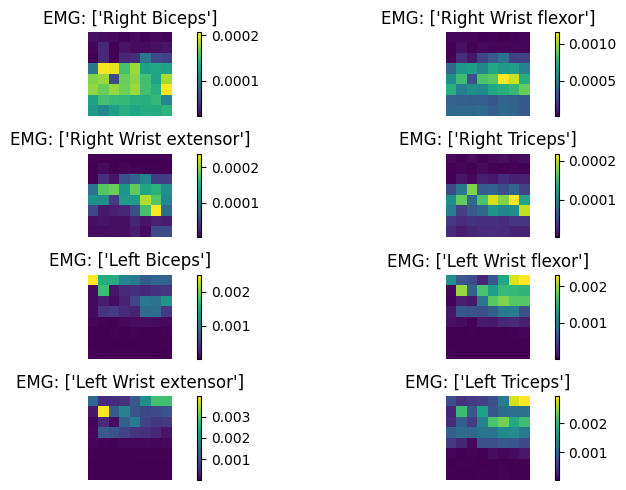

In [35]:
im = np.zeros((8, 8))

n_cols, n_rows = 4, 2

fig, axs = plt.subplots(n_cols, n_rows, figsize=(9, 5))
# Remplissage de chaque carte avec les valeurs de response correspondantes
for i, ax in enumerate(axs.flat):
    im.fill(0)  # Remise à zéro de la carte pour chaque sous-plot
    for j in range(len(ch2xy)):
        x, y = ch2xy[j]
        im[int(x), int(y)] = valid_respMean[i, j]

    image = ax.imshow(im, cmap="viridis", interpolation="nearest")
    ax.set_title("EMG: {}".format(emgs_all[i]))
    cbar = fig.colorbar(image, ax=ax)
    ax.axis("off")


plt.tight_layout()
plt.show()

In [ ]:
mean_regret_1 = np.zeros((response.shape[1], 150, 3))
q_star = 35


for emg in range(response.shape[1]):
    print("emg ", emg)
    response_emg = response[:, emg, :]
    isvalid_emg = isvalid[:, emg, :]
    respMean_emg = valid_respMean[emg, :]

    opt = BayesianOptimizer(
        ch2xy,
        response_emg,
        kernel=matk_scaled,
        likelihood=likf,
        isvalid=isvalid_emg,
        respMean_valid=respMean_emg,
    )

    regret_gpbo, baseline = opt.train(
        4,
        initial_points=1,
        repetitions=30,
        iterations=150,
        strategy="Vanilla BO",
    )
    regret_mpbo, _ = opt.train(
        4,
        repetitions=30,
        iterations=150,
        strategy="MP-BO",
        begin_strat=q_star,
        initial_points=q_star,
        follow_baseline=baseline,
    )

    mean_regret_1[emg, :, 0] = regret_gpbo.mean(0)
    mean_regret_1[emg, :, 1] = regret_mpbo.mean(0)

    plt.figure(figsize=(4, 4))
    plt.plot(regret_gpbo.mean(0), color="red", linestyle="--", label="Vanilla BO")
    plt.fill_between(
        range(150),
        regret_gpbo.mean(0) - regret_gpbo.std(0) / np.sqrt(30),
        regret_gpbo.mean(0) + regret_gpbo.std(0) / np.sqrt(30),
        color="red",
        alpha=0.2,
    )
    plt.plot(regret_mpbo.mean(0), color="tab:blue", label="MP-BO")
    plt.fill_between(
        range(150),
        regret_mpbo.mean(0) - regret_mpbo.std(0) / np.sqrt(30),
        regret_mpbo.mean(0) + regret_mpbo.std(0) / np.sqrt(30),
        color="tab:blue",
        alpha=0.2,
    )
    plt.vlines(q_star, 0, 1, linestyle="dotted", label=f"q*={q_star}", color="k")
    plt.legend()
    plt.title(f"EMG: {emg}")
    plt.show()


plt.figure(figsize=(4, 4))
plt.plot(mean_regret_1.mean(0)[:, 0], color="red", linestyle="--", label="Vanilla BO")

plt.plot(mean_regret_1.mean(0)[:, 1], color="tab:blue", label="MP-BO")

plt.vlines(q_star, 0, 1, linestyle="dotted", label=f"q*={q_star}", color="k")
plt.legend()
plt.title("Mean")